In [4]:
import pdb
import os
import re
import glob
import pandas as pd
from utils import format_prompt, get_prompt_guidelines_manifestos
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import uuid
import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from itertools import combinations
import numpy as np
import krippendorff

from prompts import ALL_PROMPTS

In [29]:
dataset_name = "FrameNews-PT"

In [30]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 14,          # General font size
    'axes.titlesize': 18,     # Title font size
    'axes.labelsize': 14,     # X and Y label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'legend.fontsize': 16,    # Legend font size
    'figure.titlesize': 18    # Figure title font size
})

In [31]:
def is_valid_uuid(s):
    try:
        val = uuid.UUID(s)
        return str(val) == s.lower()
    except ValueError:
        return False

In [32]:
# Define the function to map ground truth labels

label_map = {1: 'Economic', 2: 'Capacity and resources', 3: 'Morality', 4: 'Fairness and equality', 5: 'Legality, Constitutionality, Jurisdiction', 6: 'Policy prescription and evaluation', 7: 'Crime and punishment', 8: 'Security and defense', 9: 'Health and safety', 10: 'Quality of life', 11: 'Cultural identity', 12: 'Public opinion', 13: 'Political', 14: 'External regulation and reputation', 15: 'Other'}

def map_ground_truth_labels(label):

    label = int(re.search(r'\d+', label).group())
    # Return mapped label or original if not in map
    return label_map.get(label, label)

code2label = {k: v.lower() for k, v in label_map.items()}
label2code = {v: k for k, v in code2label.items()}
label2code["political sentiment"] = 12
label2code

{'economic': 1,
 'capacity and resources': 2,
 'morality': 3,
 'fairness and equality': 4,
 'legality, constitutionality, jurisdiction': 5,
 'policy prescription and evaluation': 6,
 'crime and punishment': 7,
 'security and defense': 8,
 'health and safety': 9,
 'quality of life': 10,
 'cultural identity': 11,
 'public opinion': 12,
 'political': 13,
 'external regulation and reputation': 14,
 'other': 15,
 'political sentiment': 12}

In [33]:
def get_results():

    results_dir = 'results'

    # Get all CSV files in the results directory
    result_files = glob.glob(os.path.join(results_dir, '*.csv'))

    # Load each CSV file and append to the list
    combined_results = pd.DataFrame()
    for file in result_files:
        df = pd.read_csv(file)
        df["model"] = len(df)*[file.split("/")[-1].split("_")[0]]
        # df['response_mapped'] = df['response'].apply(lambda x: map_ground_truth_labels(x))
        combined_results = pd.concat([combined_results, df])
    
    combined_results["response_code"] = combined_results["response_mapped"].apply(lambda x: label2code[x.lower()] if str(x) != "na" else x)
    combined_results["response_mapped"] = combined_results["response_mapped"].apply(lambda x: x.lower())
    combined_results["ground_truth1"] = combined_results["ground_truth1"].apply(lambda x: x.lower() if str(x) != "nan" else x)
    combined_results["ground_truth2"] = combined_results["ground_truth2"].apply(lambda x: x.lower() if str(x) != "nan" else x)

    # assert that combined_results['ground_truth'].unique() set is equal to all_prompts_df['ground_truth'].unique() set
    # assert set(list(combined_results['ground_truth1'].unique())) == set(combined_results['response_mapped'].unique()), \
    #     "The unique ground truth labels in combined results do not match those in the all prompts dataframe."

    return combined_results

In [34]:

def get_model_size_B(model_name: str, default: int = 2) -> int:
    """Get the model size from the model name, in Billions of parameters."""
    regex = re.search(r"((?P<times>\d+)[xX])?(?P<size>\d+)[bB]", model_name)
    if regex:
        return int(regex.group("size")) * int(regex.group("times") or 1)
    else:
        # print(f"Could not infer model size from name '{model_name}'")
        return None

In [35]:
def combine_results():

    combined_results = get_results()

    all_prompts_df = pd.read_csv('data_prompts/frames_recsys_test.csv')
    mfc =  pd.read_csv('../data/mfc_stratified_sample.csv')

    # concat mfc and all_prompts_df add none in columns where they don't match
    all_prompts_df = pd.concat([all_prompts_df, mfc], axis=0, ignore_index=True)
    all_prompts_df["label"]=[i.lower() for i in all_prompts_df["label"].tolist()]
    all_prompts_df["label1"]=[i.lower() for i in all_prompts_df["label"].tolist()]

    combined_results['model_size_B'] = combined_results['model'].apply(
        get_model_size_B)
    combined_results['model_family'] = combined_results['model'].apply(
        lambda x: x.split('-')[0])

    # sort the dataframe by model family and model size (small to large) and prompt description
    combined_results.sort_values(
        by=['model_family', 'model_size_B', 'prompt_description'], inplace=True, ignore_index=True)

    # assert that the number of rows is the same for every model-prompt_description combination
    model_prompt_counts = combined_results.groupby(
        ['model', 'prompt_description']).size()
    
    print("Before removing duplicates", len(combined_results))
    # delete duplicates in columns model, prompt_description, and prompt_id and keep the last
    combined_results = combined_results.drop_duplicates(subset=['model', 'prompt_description', 'prompt_id'], keep='last')
    print("After removing duplicates", len(combined_results))

    # assert all(model_prompt_counts == model_prompt_counts.iloc[0]), \
    #     "The number of rows is not the same for every model-prompt_description combination."

    guidelines = get_prompt_guidelines_manifestos()
    # Merge all_prompts_df with combined_results on prompt_id
    # Keep only the necessary columns from all_prompts_df
    combined_results = combined_results.merge(
        all_prompts_df[['prompt_id', "text", "primary_code", "primary_code1"]],
        on='prompt_id',
        how='left'
    )
    print(combined_results.columns)
    # raise Exception("Check the columns of combined_results")

    # Sort the dataframe again
    combined_results.sort_values(
        by=['model_family', 'model_size_B', 'prompt_description'], 
        inplace=True, 
        ignore_index=True
    )
    combined_results['full_prompt'] = combined_results.apply(
        lambda x: format_prompt(
            ALL_PROMPTS.get(x['prompt_description'], None),
            x['text'], guidelines=guidelines),
        axis=1
    )

    combined_results.insert(0, 'dataset', ["FrameNews-PT" if is_valid_uuid(x) else "mfc" for x in combined_results["prompt_id"].tolist()])

    # Save the combined results to a CSV file
    combined_results.to_csv('./results/analysis/combined_results.csv', index=False)
    print(combined_results)

    return combined_results

In [36]:
df = pd.read_csv('./results/analysis/combined_results.csv')
# print(df.primary_code1.value_counts())
# df = combine_results()
df["dataset"]= df["dataset"].apply(lambda x: "FrameNews-PT" if x == "frame-recsys" else "MFC")
df

/tmp/ipykernel_132926/2567282418.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./results/analysis/combined_results.csv')


,dataset,prompt_id,ground_truth1,ground_truth2,response_mapped,response,prompt_description,model,response_code,model_size_B,model_family,text,primary_code,primary_code1,full_prompt
0,FrameNews-PT,990ffd9d-f7ca-4df1-8394-53256b3079b7,"legality, constitutionality, jurisdiction","legality, constitutionality, jurisdiction","legality, constitutionality, jurisdiction",5,zero1,Qwen--Qwen2.5-3B-Instruct,5,3.0,Qwen,Fux suspende mudança no cálculo do ICMS sobre ...,5,5.0,"### PROMPT:\n""Fux suspende mudança no cálculo ..."
1,FrameNews-PT,c63ebc02-43ea-4293-a7e0-4798fa2da95f,economic,economic,policy prescription and evaluation,13,zero1,Qwen--Qwen2.5-3B-Instruct,6,3.0,Qwen,Volta de impostos sobre combustíveis está no r...,1,1.0,"### PROMPT:\n""Volta de impostos sobre combustí..."
2,FrameNews-PT,2a165258-901b-4e7b-b603-0070aa6aeb41,policy prescription and evaluation,policy prescription and evaluation,security and defense,7,zero1,Qwen--Qwen2.5-3B-Instruct,8,3.0,Qwen,"Após demissão no GSI, Lula quer 'novo desenho'...",6,6.0,"### PROMPT:\n""Após demissão no GSI, Lula quer ..."
3,FrameNews-PT,a91dedd4-01b9-4ffe-ac00-a888d6247f9c,security and defense,security and defense,security and defense,7,zero1,Qwen--Qwen2.5-3B-Instruct,8,3.0,Qwen,Rede interna do Tesouro Nacional foi alvo de a...,8,8.0,"### PROMPT:\n""Rede interna do Tesouro Nacional..."
4,FrameNews-PT,19cfc29b-a953-48a7-b1d9-c2d7b2b60d75,political,political,policy prescription and evaluation,13,zero1,Qwen--Qwen2.5-3B-Instruct,6,3.0,Qwen,"É sinal de que tem que rever muita coisa', diz...",13,13.0,"### PROMPT:\n""É sinal de que tem que rever mui..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156331,MFC,Immigration1.0-63090,"legality, constitutionality, jurisdiction",NaN,political,12\n\nThe article is primarily focused on the ...,zero3_noex,meta-llama--Llama-3.1-8B-Instruct,13,8.0,meta,\n\nIllegal immigrants can't rent: Nebraska to...,5,NaN,\n### CLASSIFICATION GUIDELINES: \n\nFRAMES ar...
156332,MFC,gun_control1.0-10872,policy prescription and evaluation,NaN,political,12\n\nThe article primarily discusses the poli...,zero3_noex,meta-llama--Llama-3.1-8B-Instruct,13,8.0,meta,\n\nCOMMON SENSE IS NO MATCH FOR GUN LOBBY\n\n...,6,NaN,\n### CLASSIFICATION GUIDELINES: \n\nFRAMES ar...
156333,MFC,death_penalty_23593,economic,NaN,crime and punishment,"""6"" \n\nThe article discusses the impact of",zero3_noex,meta-llama--Llama-3.1-8B-Instruct,7,8.0,meta,\n\nFLORIDA'S COSTLY 'SAVINGS'\n\nGov. Bush is...,1,NaN,\n### CLASSIFICATION GUIDELINES: \n\nFRAMES ar...
156334,MFC,Immigration1.0-19113,"legality, constitutionality, jurisdiction",NaN,political,12\n\nThe prompt is primarily about the politi...,zero3_noex,meta-llama--Llama-3.1-8B-Instruct,13,8.0,meta,\n\nThe Great Senate Immigr'A'tion Debate\n\nI...,5,NaN,\n### CLASSIFICATION GUIDELINES: \n\nFRAMES ar...


In [37]:
def check_results_either_annot(df):
    # Exclude specific model
    df = df[~df["model"].isin(["google--gemma-3-12b-it"])]
    results = []

    for (model_name, prompt_desc, dataset_name), group in df.groupby(['model', 'prompt_description', 'dataset']):
        model_name = model_name.split("--")[-1]

        if dataset_name == "FrameNews-PT":
            assert len(group) == 300, f"Expected 300 rows for {model_name}, {prompt_desc}, {dataset_name}, but got {len(group)}"
            for annot, label_col in [("1", "primary_code"), ("2", "primary_code1")]:
                y_true = group[label_col].astype(int).astype(str)
                y_pred = group["response_code"].astype(str)

                # Build true labels as sets (to allow multiple acceptable answers)
                y_true_sets = list(zip(group["primary_code"].astype(int).astype(str),
                                    group["primary_code1"].astype(int).astype(str)))

                # Evaluate "correct if it matches either annotator"
                correct = [
                    pred in (label1, label2)
                    for pred, (label1, label2) in zip(y_pred, y_true_sets)
                ]
                accuracy = sum(correct) / len(correct)
                # print(f"Accuracy: {accuracy:.4f}")

                report = classification_report(y_true, y_pred, digits=3, output_dict=True, zero_division=0)
                results.append((
                    model_name, prompt_desc, dataset_name, f"ann_{annot}",
                    report["weighted avg"]["f1-score"],
                    accuracy
                ))
        else:
            assert len(group) == 6214, f"Expected 6214 rows for {model_name}, {prompt_desc}, {dataset_name}, but got {len(group)}"
            y_true = group["primary_code"].astype(str)
            y_pred = group["response_code"].astype(str)
            report = classification_report(y_true, y_pred, digits=3, output_dict=True, zero_division=0)
            results.append((
                model_name, prompt_desc, dataset_name, "gold_label",
                report["weighted avg"]["f1-score"],
                report["accuracy"]
            ))

    results_df = pd.DataFrame(results, columns=[
        "model", "prompt_description", "dataset", "annotator",
         "weighted_f1", "accuracy"
    ])
    return results_df

df_results = check_results_either_annot(df)
print(tabulate.tabulate(df_results.sort_values(by="accuracy", ascending=False), headers='keys', tablefmt='psql'))


+----+-----------------------+----------------------+--------------+-------------+---------------+------------+
|    | model                 | prompt_description   | dataset      | annotator   |   weighted_f1 |   accuracy |
|----+-----------------------+----------------------+--------------+-------------+---------------+------------|
| 40 | gpt-4o-2024-08-06     | zero3_noex           | FrameNews-PT | ann_2       |     0.519502  |  0.61      |
| 39 | gpt-4o-2024-08-06     | zero3_noex           | FrameNews-PT | ann_1       |     0.539313  |  0.61      |
| 36 | gpt-4o-2024-08-06     | zero2                | FrameNews-PT | ann_1       |     0.534843  |  0.593333  |
| 37 | gpt-4o-2024-08-06     | zero2                | FrameNews-PT | ann_2       |     0.509068  |  0.593333  |
| 33 | gpt-4o-2024-08-06     | zero1                | FrameNews-PT | ann_1       |     0.463246  |  0.573333  |
| 34 | gpt-4o-2024-08-06     | zero1                | FrameNews-PT | ann_2       |     0.455429  |  0.57

In [38]:
# Run and print
df_final = pd.DataFrame()
for (model, dataset), group in df_results.groupby(['model', "dataset"]):
    # average "macro_f1", "weighted_f1", "precision", "recall", "accuracy" and save std in a new column 
    group = group.groupby(["annotator"]).agg(
        {
            "weighted_f1": ["mean", "std"],
            "accuracy": ["mean", "std"]
        }
    )
    group.columns = ['_'.join(col).strip() for col in group.columns.values]
    group = group.reset_index()
    group.insert(0, 'model', model)
    group.insert(1, 'dataset', dataset)
    df_final = pd.concat([df_final, group], ignore_index=True)

for dataset in df_final.dataset.unique():
    # print(tabulate.tabulate(df_final[df_final["dataset"]==dataset].sort_values(by="accuracy_mean", ascending=False), headers='keys', tablefmt='psql'))
    # print("\n")
    # print df_final as latex table
    tmp = df_final[df_final["dataset"]==dataset]

    for col in ["weighted_f1_mean", "weighted_f1_std", "accuracy_mean", "accuracy_std"]:
        tmp[col] = tmp[col].apply(lambda x: float(f"{x:.2f}"))
    print(tabulate.tabulate(tmp.sort_values(by="accuracy_mean", ascending=False), headers='keys', tablefmt='latex'))

\begin{tabular}{rlllrrrr}
\hline
    & model                 & dataset      & annotator   &   weighted\_f1\_mean &   weighted\_f1\_std &   accuracy\_mean &   accuracy\_std \\
\hline
 22 & gpt-4o-2024-08-06     & FrameNews-PT & ann\_2       &               0.49 &              0.03 &            0.59 &           0.02 \\
 21 & gpt-4o-2024-08-06     & FrameNews-PT & ann\_1       &               0.51 &              0.04 &            0.59 &           0.02 \\
 15 & Qwen2.5-7B-Instruct   & FrameNews-PT & ann\_1       &               0.46 &              0.04 &            0.54 &           0.02 \\
 16 & Qwen2.5-7B-Instruct   & FrameNews-PT & ann\_2       &               0.43 &              0.03 &            0.54 &           0.02 \\
  0 & Llama-3.1-8B-Instruct & FrameNews-PT & ann\_1       &               0.37 &              0.03 &            0.44 &           0.04 \\
  1 & Llama-3.1-8B-Instruct & FrameNews-PT & ann\_2       &               0.34 &              0.04 &            0.44 &           0.04

/tmp/ipykernel_132926/259371948.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[col] = tmp[col].apply(lambda x: float(f"{x:.2f}"))


In [39]:
shorten_labels = {'Economic': 'Economic',
 'Capacity and resources': 'Capacity&resources',
 'Morality': 'Morality',
 'Fairness and equality': 'Fairness&equality',
 'Legality, Constitutionality, Jurisdiction': 'Legality, Constit.',
 'Policy prescription and evaluation': 'Policy prescription',
 'Crime and punishment': 'Crime & punishment',
 'Security and defense': 'Security & defense',
 'Health and safety': 'Health & safety',
 'Quality of life': 'Quality of life',
 'Cultural identity': 'Cultural identity',
 'Public opinion': 'Public opinion',
 'Political': 'Political',
 'External regulation and reputation': 'External regulation',
 'Other': 'Other'}

<Figure size 1000x800 with 0 Axes>

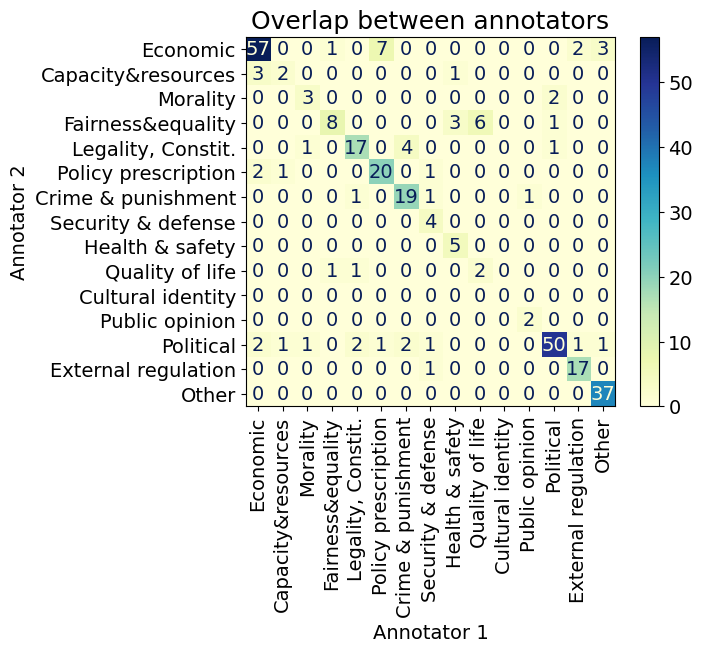

In [40]:
frames_df = pd.read_csv("./data_prompts/frames_recsys_test.csv")

cm = confusion_matrix(frames_df["primary_code"], frames_df["primary_code1"].astype(int), labels=list(label_map.keys()))

# Display confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[shorten_labels[i] for i in list(label_map.values())])
disp.plot(cmap=plt.cm.YlGnBu, xticks_rotation='vertical')  #(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f"Overlap between annotators")
plt.xlabel("Annotator 1")
plt.ylabel("Annotator 2")
# plt.tight_layout()
plt.savefig(f"results/analysis/confusion_matrix_framenews.png", bbox_inches='tight')
plt.show()
plt.close()

<Figure size 1000x800 with 0 Axes>

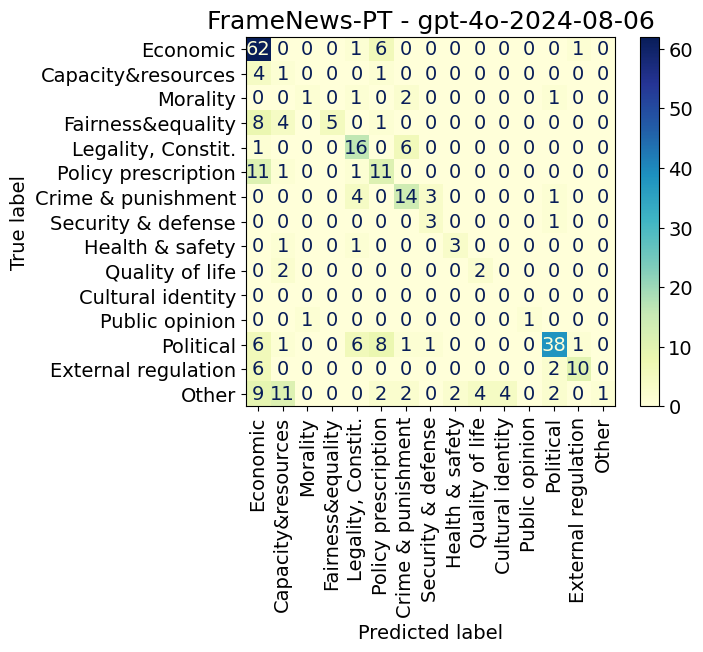

<Figure size 1000x800 with 0 Axes>

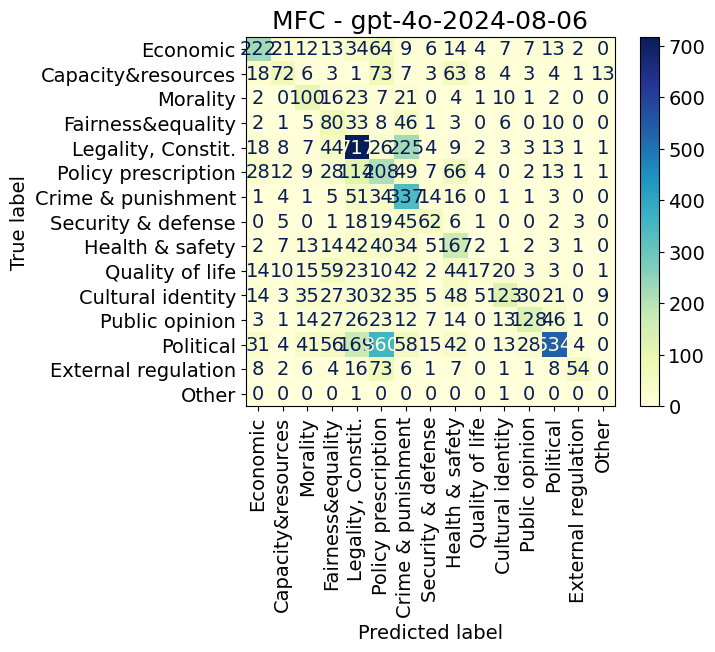

In [41]:
best_prompt = "zero3_noex"
for dataset in df.dataset.unique():
    tmp = df[(df["dataset"] == dataset) & (df["prompt_description"] == best_prompt) & (df["model"] == "gpt-4o-2024-08-06")]
    # create confusion matrix with label and response_mapped
    # Generate confusion matrix
    cm = confusion_matrix(tmp["primary_code"], tmp["response_code"].astype(int), labels=list(label_map.keys()))

    # Display confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[shorten_labels[i] for i in list(label_map.values())])
    disp.plot(cmap=plt.cm.YlGnBu, xticks_rotation='vertical')  #(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"{dataset} - gpt-4o-2024-08-06")
    # plt.tight_layout()
    plt.savefig(f"results/analysis/confusion_matrix_{dataset}_{best_prompt}_gpt4o.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [42]:
for dataset in df.dataset.unique():
    for model in df.model.unique():
        cohens = []

        if dataset == "FrameNews-PT":
            l = ["zero1", "zero2", "zero3_noex"]
        else:
            l = ["zero1", "zero2"]

        for p1, p2 in combinations(l, 2):

            tmp1 = df[(df["dataset"] == dataset) & (df["prompt_description"] == p1) & (df["model"] ==model)]
            tmp = df[(df["dataset"] == dataset) & (df["prompt_description"] == p2) & (df["model"] == model)]
            # calculate cohen's kappa between the response_mapped in tmp1 and tmp
            if len(tmp1)==len(tmp):
                cohen_kappa = cohen_kappa_score(tmp1["response_mapped"], tmp["response_mapped"])
                cohens.append(cohen_kappa)
        print(model, dataset, "cohen's kappa", np.mean(cohens), np.std(cohens))

Qwen--Qwen2.5-3B-Instruct FrameNews-PT cohen's kappa 0.41545338768645906 0.18872206741680206
Qwen--Qwen2.5-1.5B-Instruct FrameNews-PT cohen's kappa 0.21556461620280087 0.0
Qwen--Qwen2.5-7B-Instruct FrameNews-PT cohen's kappa 0.49850686398667454 0.18729228204484422
google--gemma-3-4b-it FrameNews-PT cohen's kappa 0.4501712724693381 0.14519494723809245


google--gemma-3-12b-it FrameNews-PT cohen's kappa 0.5451591942820013 0.0
gpt-4o-2024-08-06 FrameNews-PT cohen's kappa 0.7510627345621607 0.06374805992092182
meta-llama--Llama-3.2-1B-Instruct FrameNews-PT cohen's kappa 0.045921966068975806 0.0
meta-llama--Llama-3.2-3B-Instruct FrameNews-PT cohen's kappa 0.041025278360560434 0.05801850505763601
meta-llama--Llama-3.1-8B-Instruct FrameNews-PT cohen's kappa 0.5111257733220159 0.1090604586207434
Qwen--Qwen2.5-3B-Instruct MFC cohen's kappa 0.35533814818080534 0.0
Qwen--Qwen2.5-1.5B-Instruct MFC cohen's kappa 0.13567503538939596 0.0
Qwen--Qwen2.5-7B-Instruct MFC cohen's kappa 0.5089137719117107 0.0
google--gemma-3-4b-it MFC cohen's kappa 0.39735635836255523 0.0
google--gemma-3-12b-it MFC cohen's kappa -0.06572583727634163 0.0
gpt-4o-2024-08-06 MFC cohen's kappa 0.6965553613110527 0.0
meta-llama--Llama-3.2-1B-Instruct MFC cohen's kappa 0.0012478874422933162 0.0
meta-llama--Llama-3.2-3B-Instruct MFC cohen's kappa 0.004831654451077694 0.0
meta-ll

In [43]:
for dataset in df.dataset.unique():
    tmp = df[(df["dataset"] == dataset) & (df["prompt_description"] == "zero2") & (df["model"] == "gpt-4o-2024-08-06")]
    random_baseline = tmp["primary_code"].value_counts(normalize=True).max()
    print(f"Random baseline (primary_code): {random_baseline:.4f}, {dataset} - zero2 - gpt-4o-2024-08-06")

Random baseline (primary_code): 0.2333, FrameNews-PT - zero2 - gpt-4o-2024-08-06
Random baseline (primary_code): 0.2181, MFC - zero2 - gpt-4o-2024-08-06


In [ ]:
# Load data
mfc_df = pd.read_csv("../data/mfc_stratified_sample.csv")
mfc = pd.read_csv("../data/mfc_predictions.csv", index_col=0)
for col in mfc.columns:
    mfc_df[col] = mfc[col].astype(int)

for (model, prompt) in [("gpt-4o-2024-08-06", "zero1"), ("Qwen--Qwen2.5-7B-Instruct", "zero2")]:
    tmp = df[(df["dataset"] == "MFC") & (df["prompt_description"] == prompt) & (df["model"] == model)]
    # calculate cohen's kappa between the response_mapped in tmp1 and tmp
    assert len(tmp) == len(mfc), f"Expected 300 rows for {model}, {prompt}, but got {len(tmp)}"
    model = model.split("--")[-1]
    mfc_df[model] = [int(i) for i in tmp["response_code"].tolist()]

# #rename column in mfc_df
# annotators_df = pd.read_csv("../data/per_annotator_label.csv")
# annotators_df = annotators_df.rename(columns={"index": "prompt_id"})
# annotators = [i for i in annotators_df.columns.tolist() if i != "prompt_id"]
# # merge mfc_df with annotators_df on index
# mfc_df = mfc_df.merge(annotators_df, on="prompt_id", how="left")

# mfc_df
# classification_report(mfc_df["primary_code"].astype(int), mfc_df["multi_e5"].astype(int), digits=3, output_dict=True, zero_division=0)\

In [ ]:
# Load data
frames_df = pd.read_csv("./data_prompts/frames_recsys_test.csv")
npr = pd.read_csv("../data/npr_predictions.csv", index_col=0)
for col in npr.columns:
    frames_df[col] = npr[col].astype(int)
    
for (model, prompt) in [("Qwen--Qwen2.5-7B-Instruct", "zero2"), ("gpt-4o-2024-08-06", "zero3_noex")]:
    tmp = df[(df["dataset"] == "FrameNews-PT") & (df["prompt_description"] == prompt) & (df["model"] == model)]
    # calculate cohen's kappa between the response_mapped in tmp1 and tmp
    assert len(tmp) == 300, f"Expected 300 rows for {model}, {prompt}, but got {len(tmp)}"
    model = model.split("--")[-1]
    frames_df[model] = [int(i) for i in tmp["response_code"].tolist()]
frames_df.columns

Index(['prompt_id', 'text', 'label', 'label1', 'primary_code', 'primary_code1',
       'multi_e5', 'xlm_roberta', 'Qwen2.5-7B-Instruct', 'gpt-4o-2024-08-06'],
      dtype='object')

In [46]:
# Function to calculate agreement percentage for each category
def calculate_category_agreement(df, col1, col2, num_categories=15):
    agreement_stats = {}
    
    for category in range(1, num_categories+1):
        # For each category, find cases where either annotator assigned this category
        category_mask = (df[col1] == category) | (df[col2] == category)
        cases_with_category = df[category_mask]
        
        # Count total instances where the category appears
        total_instances = len(cases_with_category)
        
        # Count instances where both annotators agree on this category
        agreement_instances = len(df[(df[col1] == category) & (df[col2] == category)])
        
        # Calculate agreement percentage
        if total_instances > 0:
            agreement_percentage = (agreement_instances / total_instances) * 100
        else:
            agreement_percentage = 0
            
        agreement_stats[category] = agreement_percentage
    print(agreement_stats)
    
    return agreement_stats

In [50]:
def krippendorff_alpha_per_category(df, annotator_cols, num_categories=15):
    alpha_stats = {}

    for category in range(1, num_categories + 1):
        annotations = []

        for _, row in df.iterrows():
            ann_row = []
            for col in annotator_cols:
                val = row[col]
                if pd.isna(val):
                    ann_row.append(np.nan)
                else:
                    ann_row.append(1 if val == category else 0)
            annotations.append(ann_row)

        data = np.array(annotations, dtype='float').T  # Annotators x Items

        unique_vals = np.unique(data[~np.isnan(data)])  # Only consider non-NaN for uniqueness
        if len(unique_vals) <= 1:
            alpha_stats[category] = np.nan
            continue

        try:
            alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
        except ValueError:
            alpha = np.nan

        alpha_stats[category] = alpha

    return alpha_stats

{1: np.float64(0.8081481006982256), 2: np.float64(0.3908474576271186), 3: np.float64(0.5938983050847457), 4: np.float64(0.5511988011988012), 5: np.float64(0.7551504251144538), 6: np.float64(0.7477540707467715), 7: np.float64(0.7925820476318726), 8: np.float64(0.6604308390022676), 9: np.float64(0.7079473427596294), 10: np.float64(0.32086167800453524), 11: nan, 12: np.float64(0.7986554621848739), 13: np.float64(0.829296095753776), 14: np.float64(0.8878067053755385), 15: np.float64(0.9411533549464584)}
Model: gpt-4o-2024-08-06, Agreement: {1: np.float64(0.5759773477047188), 2: np.float64(0.03205998319436365), 3: np.float64(0.2784871115393881), 4: np.float64(0.41323185894054704), 5: np.float64(0.5661067227760339), 6: np.float64(0.3594908764789072), 7: np.float64(0.5621176561117309), 8: np.float64(0.5377373051396821), 9: np.float64(0.5938983050847457), 10: np.float64(0.3908474576271186), 11: np.float64(-0.005033557046979942), 12: np.float64(0.6655499720826354), 13: np.float64(0.647987715872

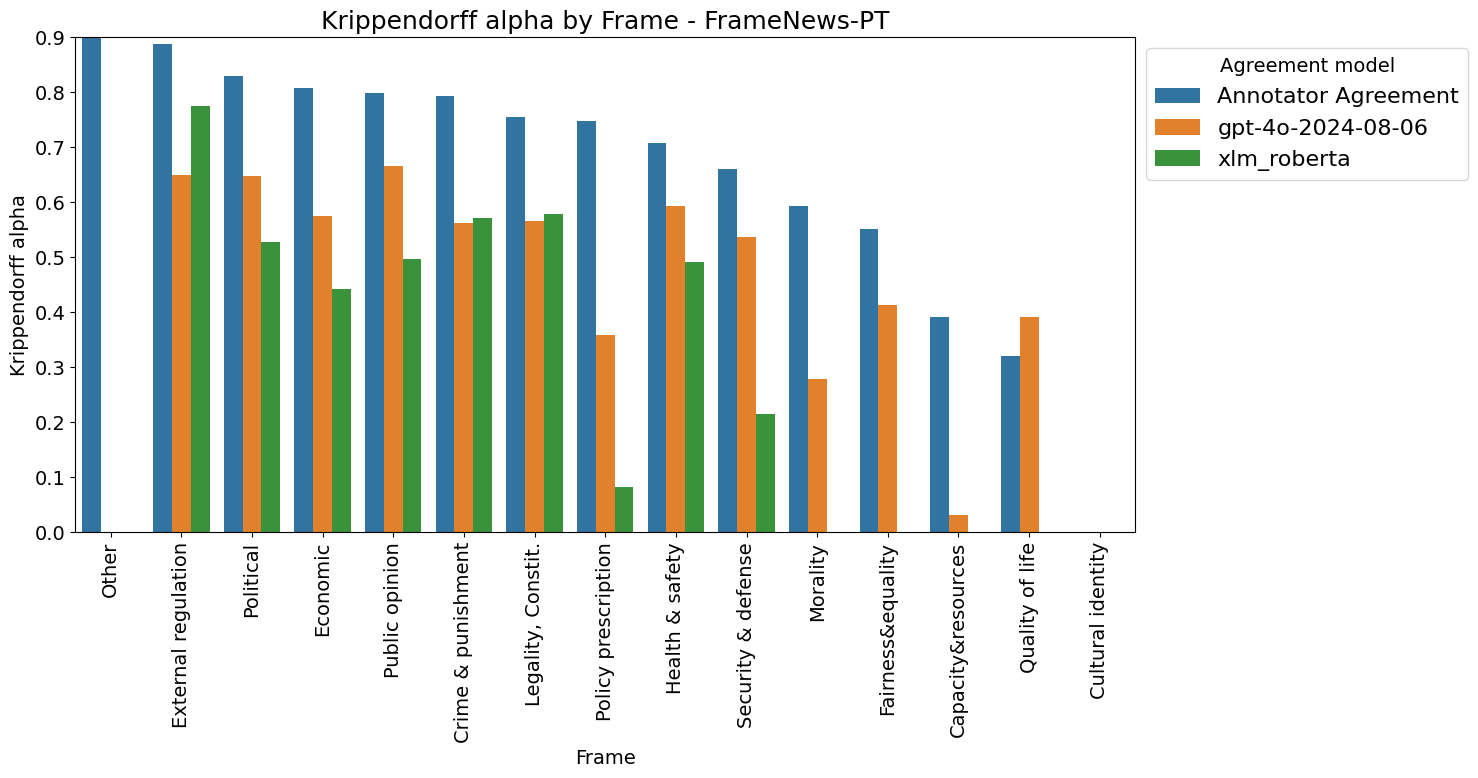

In [53]:
dataset =  "FrameNews-PT"
if dataset == "FrameNews-PT":
    df_analysis = frames_df.copy()
    annotator_col = ["primary_code", "primary_code1"]
else:
    df_analysis = mfc_df.copy()
    annotator_col = annotators
# Calculate inter-annotator agreement
annotator_agreement = krippendorff_alpha_per_category(df_analysis, annotator_col)
print(annotator_agreement)

# Calculate agreement between each model and annotator1
# Assuming model predictions are in columns named "model1", "model2", etc.
# model_columns = ["model1", "model2", "model3", "model4", "model5"]  # Adjust these column names as needed
model_columns = [ 'gpt-4o-2024-08-06', 'xlm_roberta' ] #'Qwen2.5-7B-Instruct',  'multi_e5'
model_agreements = {}

for model_col in model_columns:
    model_agreements[model_col] = krippendorff_alpha_per_category(df_analysis, ["primary_code", model_col])
    print(f"Model: {model_col}, Agreement: {model_agreements[model_col]}")

# Create a dataframe for visualization
results = []
for category in range(1, 16):
    row = {
        'Category': category,
        'Annotator Agreement': annotator_agreement[category],
        "Category_label": shorten_labels[label_map[category]],
    }
    
    # Add each model's agreement
    for model_col in model_columns:
        row[f'{model_col}'] = model_agreements[model_col][category]
    
    results.append(row)

results_df = pd.DataFrame(results)
# results_df = results_df[results_df["Category"] != 11]

# Reshape dataframe for easier plotting
plot_df = pd.melt(results_df, 
                  id_vars=['Category', 'Category_label'],
                  value_vars=['Annotator Agreement'] + [f'{model_col}' for model_col in model_columns],
                  var_name='Agreement Type',
                  value_name='Agreement Percentage')

# Order the categories by annotator agreement from highest to lowest
ordered_labels = results_df.sort_values("Annotator Agreement", ascending=False)["Category_label"].tolist()
plot_df["Category_label"] = pd.Categorical(plot_df["Category_label"], categories=ordered_labels, ordered=True)
if dataset == "mfc":
    plot_df = plot_df[plot_df["Agreement Type"] != "Annotator Agreement"]

# Create grouped bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x='Category_label', y='Agreement Percentage', hue='Agreement Type', data=plot_df)
plt.xlabel('Frame')
plt.ylabel('Krippendorff alpha')
plt.title(f'Krippendorff alpha by Frame - {dataset}')
plt.ylim(0, 0.9)
plt.legend(title='Agreement model', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"results/analysis/{dataset}_agreement_percentages_by_frame.png", bbox_inches='tight')
plt.show()


{1: np.float64(0.8081481006982256), 2: np.float64(0.3908474576271186), 3: np.float64(0.5938983050847457), 4: np.float64(0.5511988011988012), 5: np.float64(0.7551504251144538), 6: np.float64(0.7477540707467715), 7: np.float64(0.7925820476318726), 8: np.float64(0.6604308390022676), 9: np.float64(0.7079473427596294), 10: np.float64(0.32086167800453524), 11: nan, 12: np.float64(0.7986554621848739), 13: np.float64(0.829296095753776), 14: np.float64(0.8878067053755385), 15: np.float64(0.9411533549464584)}


{1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0)}
FrameNews-PT ['Annotator Agreement', 'gpt-4o-2024-08-06', 'xlm_roberta']
MFC ['gpt-4o-2024-08-06', 'xlm_roberta']
+----+---------+------------+---------------------+---------------------+------------------------+--------------+------------------------------------+
|    |   index |   Category | Category_label      | Agreement Type      |   Agreement Percentage | Dataset      | Agreement_Dataset                  |
|----+---------+------------+---------------------+---------------------+------------------------+--------------+------------------------------------|
|  0 |       0 |          1 | Economic            | Annotator Agreement |            0.808148    | FrameNews-PT | Annotator Ag

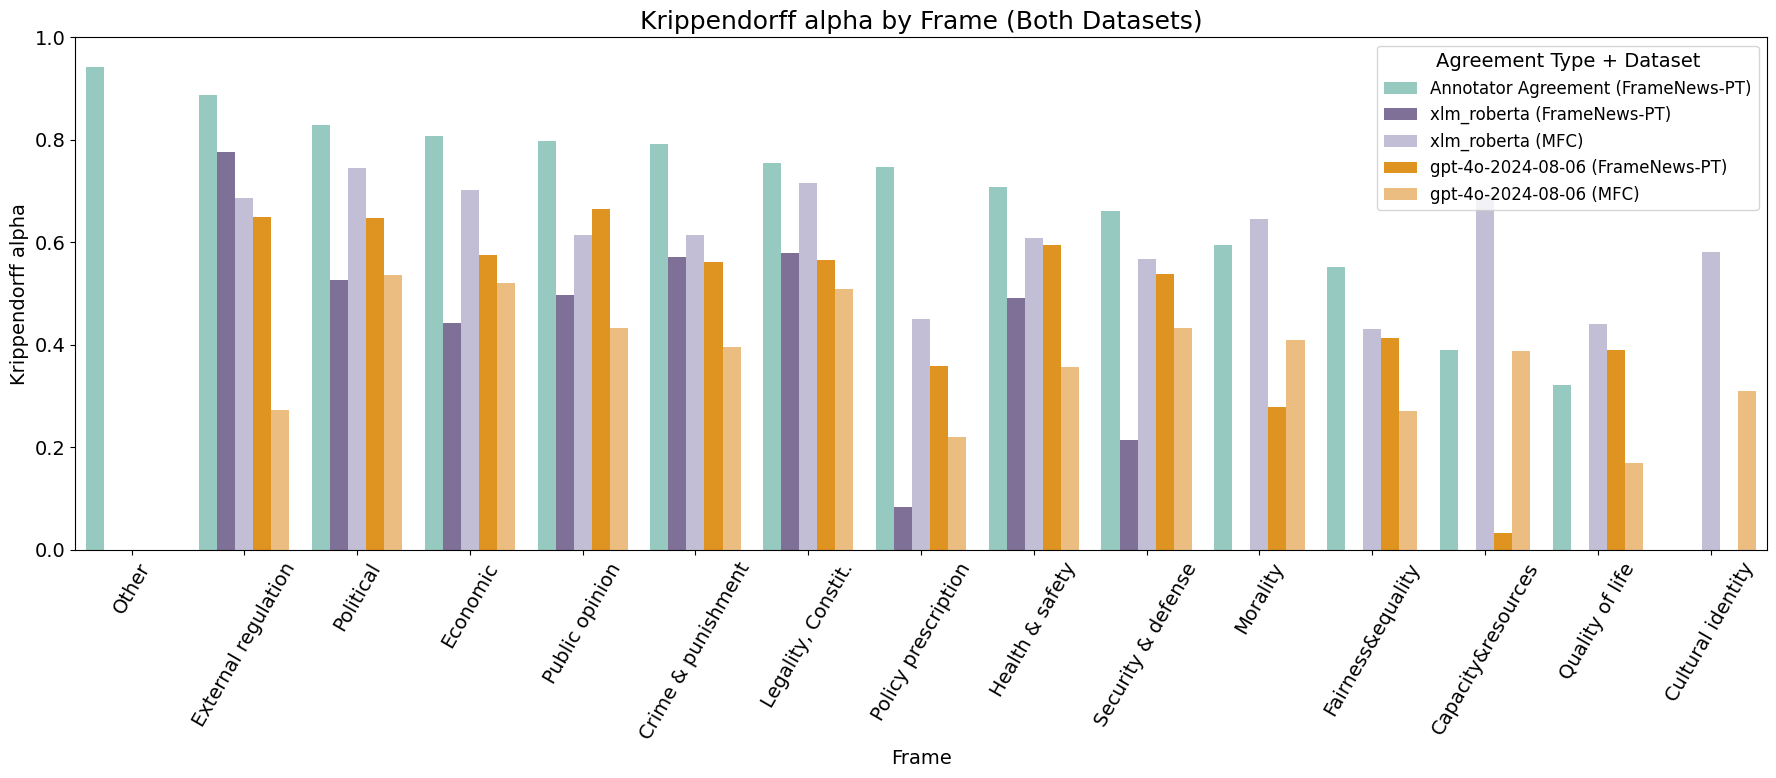

In [54]:
# Define the color dictionary
color_dict = {
    'Annotator Agreement (FrameNews-PT)': "#8DD3C7",         
    'gpt-4o-2024-08-06 (FrameNews-PT)':  '#FF9900',             
    'xlm_roberta (FrameNews-PT)': '#7C6A9D',         

    'gpt-4o-2024-08-06 (MFC)': "#FDBF6F",                 
    'xlm_roberta (MFC)': "#BEBADA",                          
}

# Function to generate results dataframe for a dataset
def generate_results_df(dataset_name):
    if dataset_name == "FrameNews-PT":
        df_analysis = frames_df.copy()
        annotator_col = ["primary_code", "primary_code1"]
    else:  # dataset == "mfc"
        df_analysis = mfc_df.copy()
        tmp = pd.read_csv("../data/mfc_2annotators.csv")
        df_analysis = df_analysis.merge(tmp, on="prompt_id", how="left")
        annotator_col = ["annotator1", "annotator2"]
        
    # Calculate inter-annotator agreement
    annotator_agreement = krippendorff_alpha_per_category(df_analysis, annotator_col)
    print(annotator_agreement)
    
    # Calculate agreement between each model and annotator1
    model_columns = ['gpt-4o-2024-08-06', 'xlm_roberta'] # 'Qwen2.5-7B-Instruct','multi_e5'
    model_agreements = {}
    for model_col in model_columns:
        model_agreements[model_col] = krippendorff_alpha_per_category(df_analysis, ["primary_code", model_col])
    
    # Create a dataframe for visualization
    results = []
    for category in range(1, 16):
        row = {
            'Category': category,
            'Annotator Agreement': annotator_agreement[category] if dataset_name == "FrameNews-PT" else None,
            "Category_label": shorten_labels[label_map[category]],
        }
        # Add each model's agreement
        for model_col in model_columns:
            row[f'{model_col}'] = model_agreements[model_col][category]
        results.append(row)
    
    results_df = pd.DataFrame(results)
    return results_df

# Generate results for both datasets
frame_recsys_results = generate_results_df("FrameNews-PT")
mfc_results = generate_results_df("MFC")

# Get the ordering based on the FrameNews-PT dataset
ordered_labels = frame_recsys_results.sort_values("Annotator Agreement", ascending=False)["Category_label"].tolist()

# Reshape both dataframes for plotting
def prepare_plot_df(results_df, dataset_name):
    model_columns = ['gpt-4o-2024-08-06', 'xlm_roberta']  #'Qwen2.5-7B-Instruct', 'multi_e5'
    
    value_vars = [f'{model_col}' for model_col in model_columns]
    if dataset_name == "FrameNews-PT":
        value_vars = ['Annotator Agreement'] + value_vars
    print(dataset_name, value_vars) 
        
    plot_df = pd.melt(results_df,
                     id_vars=['Category', 'Category_label'],
                     value_vars=value_vars,
                     var_name='Agreement Type',
                     value_name='Agreement Percentage')
    
    # Apply consistent ordering
    plot_df["Category_label"] = pd.Categorical(plot_df["Category_label"], categories=ordered_labels, ordered=True)
    
    # Add dataset column for identification
    plot_df['Dataset'] = dataset_name
    
    return plot_df

frame_recsys_plot_df = prepare_plot_df(frame_recsys_results, "FrameNews-PT")
mfc_plot_df = prepare_plot_df(mfc_results, "MFC")

combined_plot_df = pd.concat([frame_recsys_plot_df, mfc_plot_df]).reset_index()

combined_plot_df.to_csv("results/analysis/krippendorf_by_frame_by_dataset.csv", index=False)

combined_plot_df["Agreement_Dataset"] = combined_plot_df["Agreement Type"] + " (" + combined_plot_df["Dataset"] + ")"
print(tabulate.tabulate(combined_plot_df, headers='keys', tablefmt='psql'))
bar_order = [
    'Annotator Agreement (FrameNews-PT)',
    'xlm_roberta (FrameNews-PT)',
    'xlm_roberta (MFC)',
    'gpt-4o-2024-08-06 (FrameNews-PT)',
    'gpt-4o-2024-08-06 (MFC)'
]

plt.figure(figsize=(18, 8))
sns.barplot(
    x='Category_label',
    y='Agreement Percentage',
    hue='Agreement_Dataset',
    data=combined_plot_df,
    palette=color_dict,  # optionally adjust or expand this, 
    hue_order=bar_order,
)

plt.xlabel('Frame')
plt.ylabel('Krippendorff alpha')
plt.title('Krippendorff alpha by Frame (Both Datasets)')
plt.xticks(rotation=60)
plt.ylim(0, 1)
plt.legend(title='Agreement Type + Dataset', bbox_to_anchor=(1, 1), loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig("results/analysis/combined_agreement_percentages_by_frame_single_plot.png", bbox_inches='tight')
plt.show()